    Author: DANIEL TWENEBOAH ANYIMADU

# Diabetic Retinopathy Detection with Deep Learning

**-**    Diabetic Retinopathy (DR) is a leading cause of blindness among individuals with diabetes.

**-**    Early detection and timely treatment can prevent vision loss.

**-**    This project leverages Convolutional Neural Networks (CNNs), a powerful class of deep learning models, to automatically analyze retinal images and classify them into different stages of DR.

**NB: Pure Deep Learning (DL) Approach Using APTOS-2019 Dataset**

# IMPORT LIBRARIES (MODULES)

In [1]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from PIL import Image
from glob import glob
import random

# Libraries for data preprocessing, data augmentation and creating data generator
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for feature extraction and classification using deep learning
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

# Libraries for evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# EXPLORATORY DATA ANALYSIS (EDA)

**Handling Grountruth:**
    
    Loading and visualizing the groundtruth (labels) from a csv file

In [2]:
# Define file path
dir_path = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Coursera_Diabetic Retinopathy Detection with Artificial Intelligence/train/APTOS2019" # Set path to directory
groundtruth_path = os.path.join(dir_path, "train.csv") # Set path to groundtruth

# Load groundtruth data to a dataframe
groundtruth_df = pd.read_csv(groundtruth_path)
groundtruth_df.head() # Visualize the first 5 rows of the groundtruth data

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


    Mapping "diagnosis" values to "labels" in dataframe

In [3]:
# Map diagnosis values to their respective labels
labels = {0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}

# Create "labels" column based on diagnosis values
groundtruth_df["labels"] = groundtruth_df["diagnosis"].map(labels)
groundtruth_df.head()

,id_code,diagnosis,labels
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferative DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No DR
4,005b95c28852,0,No DR


    Class distribution of diagnosis labels visualization

No DR               1805
Moderate             999
Mild                 370
Proliferative DR     295
Severe               193
Name: labels, dtype: int64
Total Number of counts:  3662


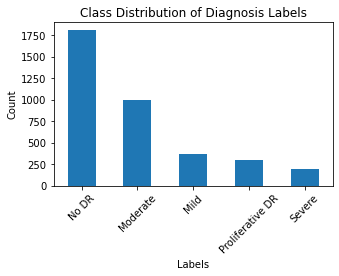

In [4]:
labels_count = groundtruth_df["labels"].value_counts()                                # Count the occurrences of each label
print(labels_count); print("Total Number of counts: ", len(groundtruth_df["labels"])) # Print labels count 

# A bar plot of the class distribution
plt.figure(figsize = (5, 3))
labels_count.plot(kind = "bar")
plt.title("Class Distribution of Diagnosis Labels"); plt.xlabel("Labels"); plt.ylabel("Count"); plt.xticks(rotation = 45)
plt.show()

    Plot a pie chart showing the percentage of diagnosis per label

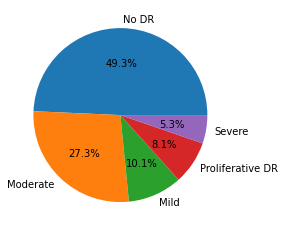

In [5]:
diagnosis = np.array([1805, 999, 370, 295, 193])
label = ["No DR", "Moderate", "Mild", "Proliferative DR", "Severe"]

plt.pie(diagnosis, labels = label, autopct = "%1.1f%%")
plt.show()

**Handling Training Dataset:**

    Mapping "image files" to "id_code"

In [6]:
image_dir = "C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Coursera_Diabetic Retinopathy Detection with Artificial Intelligence/train/APTOS2019/train_images" # Set path to train_images directory

# Get a list of image path using glob and then create a dictionary to map image file to id_code
image_path = glob(os.path.join(image_dir, "*.png")) 
image_file = {os.path.splitext(os.path.basename(path))[0] : path for path in image_path}

# Add image file and image pixel columns to the groundtruth dataframe
groundtruth_df["image_file"] = groundtruth_df["id_code"].map(image_file)
groundtruth_df["image_pixel"] = groundtruth_df["image_file"].map(lambda x: np.asarray(Image.open(x).resize((64, 64))))

# Convert image pixels to numpy array and normalize (0:255) them
image_pixel = np.asarray(groundtruth_df['image_pixel'].tolist())
image_pixel = image_pixel/255
groundtruth_df.head() # Visualize added image file and image pixel in dataframe

,id_code,diagnosis,labels,image_file,image_pixel
0,000c1434d8d7,2,Moderate,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Co...,"[[[2, 1, 2], [2, 1, 1], [1, 1, 1], [2, 1, 1], ..."
1,001639a390f0,4,Proliferative DR,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Co...,"[[[2, 1, 2], [3, 1, 2], [3, 1, 2], [3, 1, 2], ..."
2,0024cdab0c1e,1,Mild,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Co...,"[[[3, 1, 2], [3, 1, 2], [3, 1, 2], [3, 1, 2], ..."
3,002c21358ce6,0,No DR,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Co...,"[[[1, 1, 0], [2, 0, 1], [2, 1, 0], [1, 1, 0], ..."
4,005b95c28852,0,No DR,C:/Users/dtany/Desktop/MAIA_MASTERS_STUDIES/Co...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


    Visualization of Diabetic Retinopathy stages

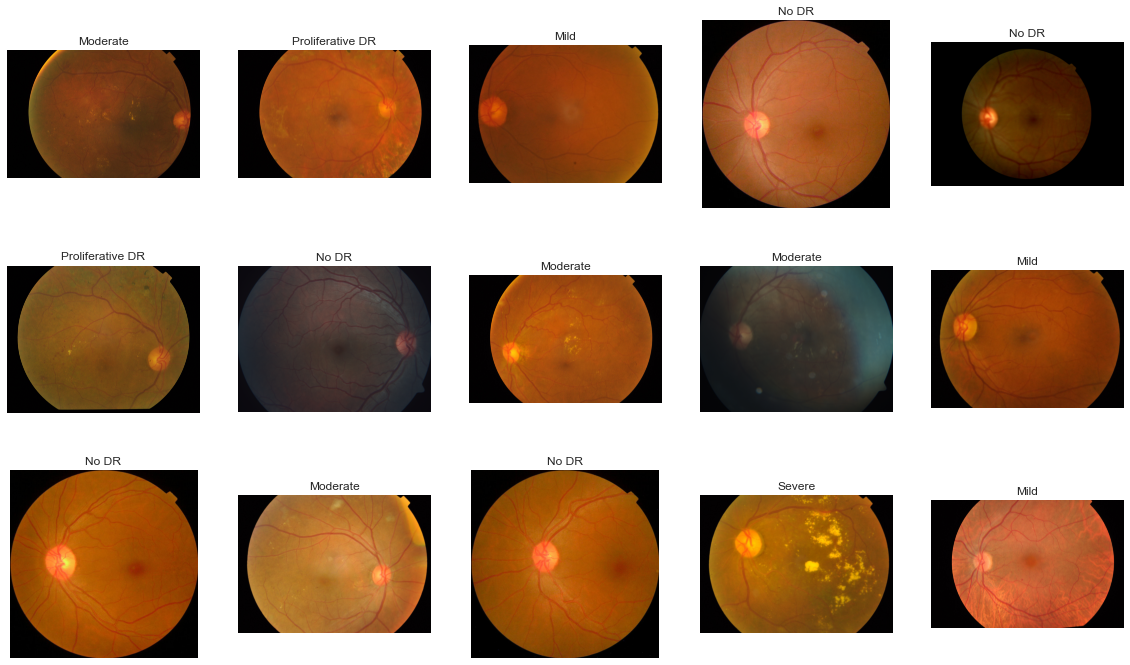

In [7]:
sns.set_style("white")
count = 1
plt.figure(figsize = [20, 20])

for img_name, diagnosis in zip(groundtruth_df["image_file"][:15], groundtruth_df["labels"][:15]):
    img = cv.imread(os.path.join(image_dir, img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert image to RGB color space
    plt.subplot(5, 5, count); plt.imshow(img); plt.title(diagnosis); plt.axis("off")
    count += 1
    
plt.show()

# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [8]:
ndr_data = groundtruth_df[groundtruth_df["diagnosis"] == 0]
mil_data = groundtruth_df[groundtruth_df["diagnosis"] == 1]
mod_data = groundtruth_df[groundtruth_df["diagnosis"] == 2]
sev_data = groundtruth_df[groundtruth_df["diagnosis"] == 3]
pro_data = groundtruth_df[groundtruth_df["diagnosis"] == 4]

# Given class distribution
ndr_cases = 1805; mil_cases = 370; mod_cases = 999; sev_cases = 193; pro_cases = 295

# Calculate the target number of samples for each class (upsampling)
target_samples = 1000 # max(ndr_cases, mil_cases, mod_cases, sev_cases, pro_cases)

# Upsampling "" and "" and downsample ""
ndr_downsampled = resample(ndr_data, replace = False, n_samples = 1205, random_state = 42)                     # Without replacement
mil_upsampled = resample(mil_data, replace = True, n_samples = target_samples, random_state = 42)              # With replacement
# mod_upsampled = resample(mod_data, replace = True, n_samples = target_samples, random_state = 42)            # Without replacement
sev_upsampled = resample(sev_data, replace = True, n_samples = target_samples, random_state = 42)              # With replacement
pro_upsampled = resample(pro_data, replace = True, n_samples = target_samples, random_state = 42)              # With replacement

# Shuffle resampled data to avoid any learning bias
resampled_data = pd.concat([ndr_downsampled, mil_upsampled, mod_data, sev_upsampled, pro_upsampled])
resampled_data = resampled_data.sample(frac = 1, random_state = 42)

    Plot of resampled diabetic retinopathy dataset class distribution

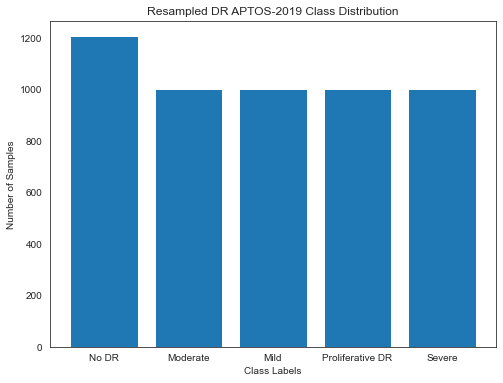

In [9]:
# Count the occurrences of each class in the resampled data
class_counts = resampled_data['labels'].value_counts()

# Get the class labels and their respective counts
class_labels = ["No DR", "Moderate", "Mild", "Proliferative DR", "Severe"]
class_counts = [class_counts[0], class_counts[1], class_counts[2], class_counts[3], class_counts[4]]

# Plot the class distribution
plt.figure(figsize = (8, 6))
plt.bar(class_labels, class_counts)
plt.title("Resampled DR APTOS-2019 Class Distribution"); plt.xlabel("Class Labels"); plt.ylabel("Number of Samples")
plt.show()

    Data shuffling and train-test split

In [10]:
train, test = train_test_split(resampled_data, test_size = 0.3, random_state = 42)

    Runtime augmentation and data generators for training and test data

In [11]:
# For training datagenerator, we add normalization, shear_range ...
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, validation_split = 0.15)

# For test datagenerator, we add normalization
test_datagen = ImageDataGenerator(rescale = 1./255)

    Data generator creation for training, validation and test dataset

In [12]:
train_generator = train_datagen.flow_from_dataframe(train, x_col = "image_file", y_col = "labels", target_size = (64, 64), color_mode = "rgb", class_mode = "categorical", batch_size = 32, subset = "training")
validation_generator = train_datagen.flow_from_dataframe(train, x_col = "image_file", y_col = "labels", target_size = (64, 64),color_mode = "rgb", class_mode = "categorical", batch_size = 32, subset = "validation")
test_generator = test_datagen.flow_from_dataframe(test, x_col = "image_file", y_col = "labels", target_size = (64, 64), color_mode = "rgb", class_mode = "categorical",  shuffle = False, batch_size = 32)

Found 3096 validated image filenames belonging to 5 classes.
Found 546 validated image filenames belonging to 5 classes.
Found 1562 validated image filenames belonging to 5 classes.


# BUILD CNN BASED DEEP LEARNING MODEL

    CNN model implementation

In [13]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation = "relu", input_shape = (64, 64, 3))) # First Layer (Input Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation = "relu", input_shape = (64, 64, 3))) # Second Layer (Hidden Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = (64, 64, 3))) # Third Layer (Output Layer)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(32))
model.add(Dense(5, activation = 'softmax'))

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

    Training a CNN model with image data

In [ ]:
batch_size = 32  # number of samples processed before the model is updated
epochs = 30      # number of complete passes through the training dataset
 
history = model.fit(train_generator, epochs = epochs, batch_size = batch_size, validation_data = validation_generator, verbose = 2)

score = model.evaluate(test_generator)
print('Test accuracy:', score[1])

Epoch 1/30
97/97 - 433s - loss: 1.4158 - acc: 0.3624 - val_loss: 1.2332 - val_acc: 0.5037 - 433s/epoch - 4s/step
Epoch 2/30
97/97 - 385s - loss: 1.2096 - acc: 0.5003 - val_loss: 1.1371 - val_acc: 0.5440 - 385s/epoch - 4s/step
Epoch 3/30
97/97 - 361s - loss: 1.1251 - acc: 0.5368 - val_loss: 1.1443 - val_acc: 0.5385 - 361s/epoch - 4s/step
Epoch 4/30


    Model loss graph

In [ ]:
# Plot the training and validation loss at each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

    Model accuracy graph

In [ ]:
# Plot the training and validation accuracy at each epoch
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy"); plt.ylabel("accuracy"); plt.xlabel("epoch")
plt.legend(["acc", "val_acc"], loc = "lower right")
plt.show()

# EVALUATION METRICS

    Make predictions on the test data

In [ ]:
pred_acc = model.evaluate(test_generator); print(f"Test accuracy: {pred_acc}")

    Other evaluation metrics

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
y_true = test_generator.classes             # Get true labels from the test generator

# Predict probabilities for test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis = 1)  # Convert probabilities to class labels


accuracy = accuracy_score(y_true, y_pred); print("accuracy:", accuracy)                           # Calculate accuracy
precision = precision_score(y_true, y_pred, average = 'weighted'); print("precision:", precision) # Calculate precision
recall = recall_score(y_true, y_pred, average = 'weighted'); print("recall:", recall)             # Calculate recall
f1 = f1_score(y_true, y_pred, average = 'weighted'); print("F1-score:", f1)                       # Calculate F1-score
bma = balanced_accuracy_score(y_true, y_pred); print("Balanced Multiclass Accuracy (BMA):", bma)  # Calculate BMA

    Plot confusion matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred); print("Confusion Matrix:\n", cm)                           # Calculate confusion matrix

# Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of APTOS 2019 Dataset (DL Approach)')
plt.show()